# Restricted Boltzmann Machines - MNIST #

In [1]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from annpy.models.rbm import RBM, CDOptimizer
from annpy.metrics import count_fails
from annpy.training.unsupervised_trainer import UnsupervisedTrainer, ValidationGranularity
import torchtrainer
from torchtrainer.callbacks import Logger
from torchtrainer.utils.data import UnsuperviseDataset

TRAIN = True
EPOCHS = 10
MODEL_PATH = 'models_saved'

First some auxiliary function definitions to convert torch Images to PyTorch Tensors to images and viceversa 

In [2]:
def tensor_to_numpy_matrix(vector, shape=(28, 28)):
    return vector.numpy().reshape(*shape)

Load MNIST training database using python-mnist package

In [3]:
def tensor_to_binary_tensor(tensor):
    return tensor.apply_(lambda x: 1.0 if x > 0 else 0.0)

def image_to_tensor(img):
    return torch.Tensor([1.0 if x == '#' else 0.0 for x in img])

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Lambda(lambda x: x.view(x.numel())),
                                     tensor_to_binary_tensor])

training_dataset = UnsuperviseDataset(MNIST('data', train=True, transform=data_transform, download=True))

data_loader = DataLoader(training_dataset,
                          batch_size=2048,
                          shuffle=True,
                          num_workers=4,
                           )
test_dataset = UnsuperviseDataset(MNIST('data', train=False, transform=data_transform, download=True))
valid_dataloader = DataLoader(test_dataset,
                          batch_size=2048,
                          shuffle=True,
                          num_workers=4,
                           )
ROW_CELLS = 28
COL_CELLS = 28
CELLS = ROW_CELLS * COL_CELLS

Turn training images list into a PyTorch matrix

Lets initialize the Restricted Boltzman Machine network with many inputs as image size units and 300 hidden units

In [4]:
network = RBM(CELLS, 300)

In [5]:
network

RBM (784 -> 300)

If there was a pretrained network, load it

In [6]:
#network_path = os.path.join(MODEL_PATH, 'network1.model')
#if os.path.exists(network_path):
#    network.load_state_dict(torch.load(network_path))
#    print("Pretrained network loaded!")

Train the network 20 epochs over all pattern images and meanwhile registering training time & error of training per epoch. The training error is computed by counting all diferences between pattern and its reconstruction.

In [7]:
optimizer = CDOptimizer(network, lr=0.1)
trainer = UnsupervisedTrainer(model=network,
                              optimizer=optimizer,
                              callbacks=[Logger()],
                              logging_frecuency=10,
                              validation_granularity=ValidationGranularity.AT_EPOCH)

In [8]:
if TRAIN:
    trainer.train(data_loader,
                  valid_dataloader=valid_dataloader,
                  epochs=EPOCHS)

epoch: 0/10,	step: 9/30,	train_reconstruction_loss: 0.246
epoch: 0/10,	step: 19/30,	train_reconstruction_loss: 0.210
epoch: 0/10,	step: 29/30,	train_reconstruction_loss: 0.180,	val_reconstruction_loss: 0.158
epoch: 1/10,	step: 9/30,	train_reconstruction_loss: 0.160
epoch: 1/10,	step: 19/30,	train_reconstruction_loss: 0.145
epoch: 1/10,	step: 29/30,	train_reconstruction_loss: 0.136,	val_reconstruction_loss: 0.131
epoch: 2/10,	step: 9/30,	train_reconstruction_loss: 0.130
epoch: 2/10,	step: 19/30,	train_reconstruction_loss: 0.125
epoch: 2/10,	step: 29/30,	train_reconstruction_loss: 0.122,	val_reconstruction_loss: 0.119
epoch: 3/10,	step: 9/30,	train_reconstruction_loss: 0.119
epoch: 3/10,	step: 19/30,	train_reconstruction_loss: 0.115
epoch: 3/10,	step: 29/30,	train_reconstruction_loss: 0.112,	val_reconstruction_loss: 0.109
epoch: 4/10,	step: 9/30,	train_reconstruction_loss: 0.109
epoch: 4/10,	step: 19/30,	train_reconstruction_loss: 0.107
epoch: 4/10,	step: 29/30,	train_reconstruction_loss

### Trainining measurements ###

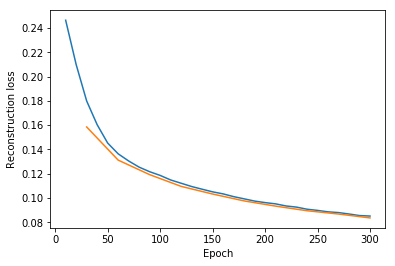

In [9]:
trainer.history.step_plot('train_reconstruction_loss')
trainer.history.step_plot('val_reconstruction_loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction loss')
plt.show()

## Weights Visualization ##

In [10]:
def digitplot(x, show=True):
    plt.matshow(tensor_to_numpy_matrix(x))
    if show:
        plt.show()

* Visible biases

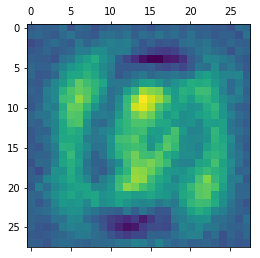

In [11]:
digitplot(network.visible_biases.data)

* Weights associated to some hidden units

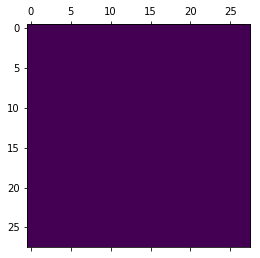

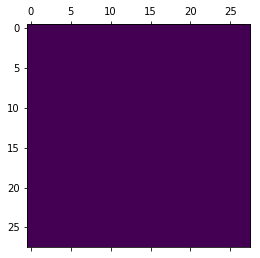

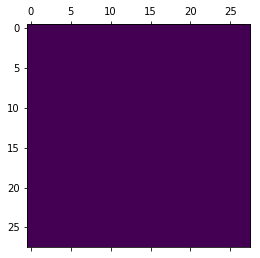

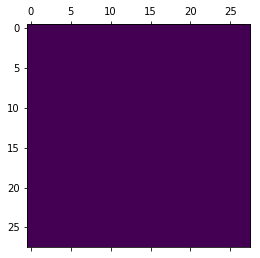

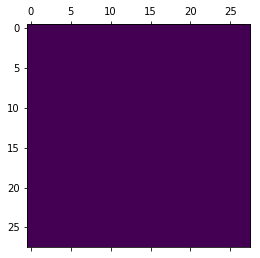

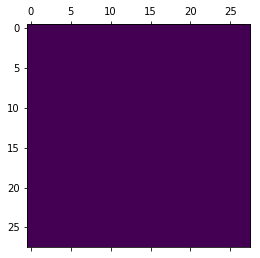

In [12]:
for i in range(0,300,50):
    weights = torch.t(network.weights)[i].long()
    digitplot(weights.data)

In [13]:
SAVE_WEIGHTS_IMAGES = False

if SAVE_WEIGHTS_IMAGES:
    fig = plt.figure(figsize=(3, 3))

    for i in range(0,300):
        weights = torch.t(network.weights.data)[i].long()
        digitplot(weights, show=False)
        plt.savefig('weights/{}.png'.format(i))

## Pattern reconstruction ##

* Feeding with partially filled digits can reconstruct its entirely

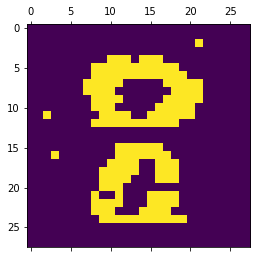

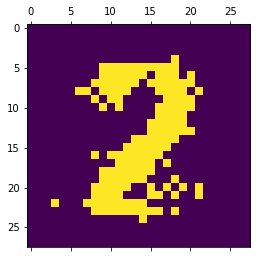

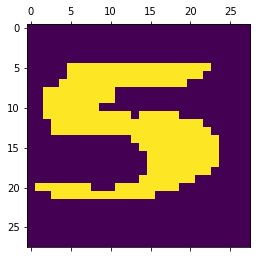

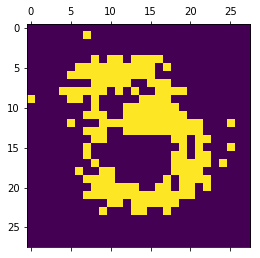

In [14]:
patterns = ('............................'
'............................'
'.....................#......'
'............................'
'..........###.###...........'
'........###########.........'
'........############........'
'.......#####.....#####......'
'.......####.......####......'
'........####.....#####......'
'........###.....#####.......'
'..#......####..######.......'
'........###########.........'
'............................'
'............................'
'...........######...........'
'...#.......#######..........'
'..........####..###.........'
'.........#####..###.........'
'.........####...###.........'
'.........###................'
'........#..#...####.........'
'........####...####.........'
'........###...####..........'
'.........###########........'
'............................'
'............................'
'............................',
###############################
'............................'
'............................'
'............................'
'............................'
'............................'
'.....##################.....'
'.....#################......'
'....################........'
'..#########.................'
'..#########.................'
'..#######...................'
'..###########.#####.........'
'...###################......'
'...####################.....'
'.............###########....'
'..............##########....'
'...............#########....'
'...............#########....'
'...............########.....'
'..............#######.......'
'.#######...########.........'
'...#############............'
'............................'
'............................'
'............................'
'............................'
'............................'
'............................'
)

tensors = [image_to_tensor(pattern) for pattern in patterns]
#print(type(tensors[0]))
for x in tensors:
    digitplot(x)
    digitplot(network.reconstruct(Variable(x), 10).data)

* Also like Hopfield networks (but with more capacity and without spinning glasses) can reconstruct the entire pattern with a noisy one

Noise factor: 0.1
Original pattern: 


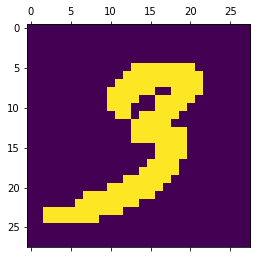

Disturbed pattern: 


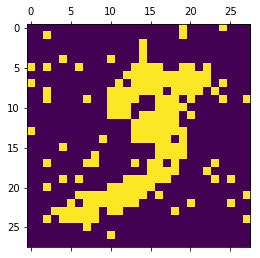

Reconstructed pattern: 


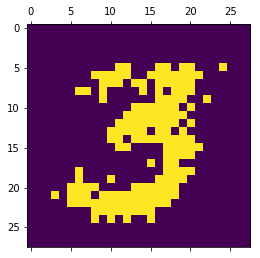

In [15]:
import numpy as np

noise_factor = float(input("Noise factor: "))

image_tensor = training_dataset[np.random.randint(len(training_dataset))]

def perturb_pattern(tensor, noise_factor=0.5):
    if noise_factor > 1.0:
        raise Exception("Noise factor must be between 0 and 1")
    
    x = torch.bernoulli(torch.ones(CELLS) * noise_factor)
    
    return (x - tensor).pow(2)

disturbed_pattern = perturb_pattern(image_tensor, noise_factor)
print("Original pattern: ")
digitplot(image_tensor)
print("Disturbed pattern: ")
digitplot(disturbed_pattern)
print("Reconstructed pattern: ")
#print(image_tensor)
digitplot(network.reconstruct(Variable(image_tensor), 10).data)

In [16]:
def hiddenshow(tensor):
    plt.matshow(tensor_to_numpy_matrix(tensor, shape=(30,10)))
    #plt.show()

In [17]:
SAVE_HIDDEN_PROBAS = False

if SAVE_HIDDEN_PROBAS:
    fig = plt.figure(figsize=(2, 6))
    images, labels = mndata.load_testing()
    images = images[:500]
    labels = labels[:500]
    for digit in range(0,10):
        for i, image_target in enumerate(zip(images, labels)):
            image, target = image_target
            x = network.proba_h_given_v(torch.Tensor(mnist_image_to_list(image)))
            hiddenshow(x)
            plt.savefig('hidden/{}/{}.png'.format(digit, target))

## Training the second network ##

In [18]:
data_transform_2 = transforms.Compose([transforms.ToTensor(),
                                       transforms.Lambda(lambda x: x.view(x.numel())),
                                       tensor_to_binary_tensor,
                                       transforms.Lambda(lambda x: network.sample_h_given_v(Variable(x)).data)])
transformed_training_dataset = UnsuperviseDataset(MNIST('data', train=True, transform=data_transform_2, download=True))
transformed_test_dataset = UnsuperviseDataset(MNIST('data', train=False, transform=data_transform_2, download=True))
data_loader_2 = DataLoader(transformed_training_dataset,
                          batch_size=2048,
                          shuffle=True,
                          num_workers=4,
                           )
test_data_loader_2 = DataLoader(transformed_test_dataset,
                          batch_size=2048,
                          shuffle=True,
                          num_workers=4,
                           )

In [19]:
network2 = RBM(300, 10)
optimizer = CDOptimizer(network2, lr=0.1)
trainer_2 = UnsupervisedTrainer(model=network2,
                              optimizer=optimizer,
                              callbacks=[Logger()],
                              logging_frecuency=10,
                              validation_granularity=ValidationGranularity.AT_LOG)

In [20]:
#network_path = os.path.join(MODEL_PATH, 'network2.model')

#if os.path.exists(network_path):
#    network2.load_state_dict(torch.load(network_path))
#    print("Pretrained network loaded!")

In [21]:
if TRAIN:
    trainer_2.train(data_loader_2,
                    valid_dataloader=test_data_loader_2,
                    epochs=EPOCHS)

epoch: 0/10,	step: 9/30,	train_reconstruction_loss: 0.467,	val_reconstruction_loss: 0.436
epoch: 0/10,	step: 19/30,	train_reconstruction_loss: 0.429,	val_reconstruction_loss: 0.422
epoch: 0/10,	step: 29/30,	train_reconstruction_loss: 0.420,	val_reconstruction_loss: 0.417
epoch: 1/10,	step: 9/30,	train_reconstruction_loss: 0.417,	val_reconstruction_loss: 0.415
epoch: 1/10,	step: 19/30,	train_reconstruction_loss: 0.414,	val_reconstruction_loss: 0.411
epoch: 1/10,	step: 29/30,	train_reconstruction_loss: 0.410,	val_reconstruction_loss: 0.407
epoch: 2/10,	step: 9/30,	train_reconstruction_loss: 0.407,	val_reconstruction_loss: 0.404
epoch: 2/10,	step: 19/30,	train_reconstruction_loss: 0.404,	val_reconstruction_loss: 0.400
epoch: 2/10,	step: 29/30,	train_reconstruction_loss: 0.399,	val_reconstruction_loss: 0.397
epoch: 3/10,	step: 9/30,	train_reconstruction_loss: 0.395,	val_reconstruction_loss: 0.393
epoch: 3/10,	step: 19/30,	train_reconstruction_loss: 0.392,	val_reconstruction_loss: 0.389
epo

In [29]:
#fig = plt.figure(figsize=(2, 6))
test_dataset = MNIST('data', train=False, transform=data_transform, download=True)
from collections import Counter
import operator
for digit in range(0,10):
    print("..........................{}........................................".format(digit))
    target_classes = Counter()
    for i in range(0, 1000):
        image, target = test_dataset[i]
        if target == digit:
            x = network.sample_h_given_v(Variable(image.unsqueeze(0)))
            x = network2.sample_h_given_v(x)
            target_classes[tuple(x.data[0])] += 1
            #print("Target {}: {}".format(target, list(x)))
    for k, c in sorted(target_classes.items(), key=operator.itemgetter(1), reverse=True):
        print(k, ":", c)

..........................0........................................
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0) : 24
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) : 21
(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0) : 5
(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0) : 4
(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0) : 4
(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) : 3
(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0) : 3
(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0) : 2
(1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0) : 2
(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0) : 1
(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0) : 1
(1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0) : 1
(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0) : 1
(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0) : 1
(1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0) : 1
(1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) : 1
(0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0) : 20
(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0) : 16
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0) : 14
(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0) : 10
(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0) : 6
(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0) : 6
(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0) : 5
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0) : 4
(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) : 3
(0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0) : 2
(0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0) : 2
(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0) : 1
(0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) : 1
(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0) : 1
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0) : 1
(0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0) : 1
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0) : 1
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0) : 1
(1.0, 

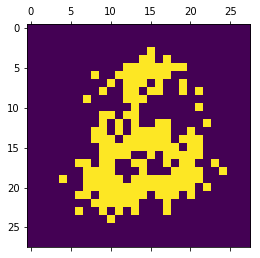

In [33]:
#x = network2.sample_v_given_h(torch.Tensor([1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]))
#for _ in range(20):
x = network2.sample_v_given_h(torch.bernoulli(Variable(torch.ones(1,10)*0.5)))
x = network.sample_v_given_h(x)
digitplot(x.data)

In [34]:
torch.save(network.state_dict(), 'models_saved/network1.model')
torch.save(network2.state_dict(), 'models_saved/network2.model')